Let's start here! If you can directly link to an image relevant to your notebook, such as [canonical logos](https://github.com/numpy/numpy/blob/main/doc/source/_static/numpylogo.svg), do so here at the top of your notebook. You can do this with Markdown syntax,

> `![<image title>](http://link.com/to/image.png "image alt text")`

or edit this cell to see raw HTML `img` demonstration. This is preferred if you need to shrink your embedded image. **Either way be sure to include `alt` text for any embedded images to make your content more accessible.**

<img src="images/ProjectPythia_Logo_Final-01-Blue.svg" width=250 alt="Project Pythia Logo"></img>

# Spherical Polygons and Areas

---

## Overview
Determine the calculations of a spherical polygons based on a unit sphere

1. Determine clockwise/counterclockwise ordering of points on spherical polygon
1. Determine if a given point is within a spherical polygon
1. Area and Permieter of quadrilateral patch on a unit sphere
1. Mean center of spherical polygon (TODO)

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Numpy](https://foundations.projectpythia.org/core/numpy.html) | Necessary | |
| [Pandas](https://foundations.projectpythia.org/core/numpy.html) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | Will be used for plotting |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Helpful | Will be used for plotting |

- **Time to learn**: 40 minutes

---

## Imports

In [44]:
import pandas as pd       # reading in data for location information from text file
#import numpy as np        # working with arrays, vectors, cross/dot products, and radians

from pyproj import Geod   # working with the Earth as an ellipsod (WGS-84)
#import geopy.distance     # working with the Earth as an ellipsod

import matplotlib.pyplot as plt                        # plotting a graph
from cartopy import crs as ccrs, feature as cfeature   # plotting a world map

In [45]:
# Get all Coordinates for Locations
location_df = pd.read_csv("../location_full_coords.txt")
location_df = location_df.rename(columns=lambda x: x.strip()) # strip excess white space from column names and values
location_df.head()

,name,latitude,longitude,cart_x,cart_y,cart_z,rho,theta,phi,polar_x,polar_y,polar_z
0,arecibo,18.3441,-66.7527,2.389526e+06,-5.562495e+06,2.007347e+06,6378137.0,-1.165054,1.250631,-5.562495e+06,2.389526e+06,2.007347e+06
1,boulder,40.0150,-105.2705,-1.286558e+06,-4.712394e+06,4.101066e+06,6378137.0,1.304276,0.872403,-4.712394e+06,-1.286558e+06,4.101066e+06
2,boston,42.3601,-71.0589,1.529809e+06,-4.457769e+06,4.297512e+06,6378137.0,-1.240212,0.831473,-4.457769e+06,1.529809e+06,4.297512e+06
3,red woods,41.4017,-124.0417,-2.678169e+06,-3.964322e+06,4.218080e+06,6378137.0,0.976657,0.848200,-3.964322e+06,-2.678169e+06,4.218080e+06
4,houston,29.5518,-95.0982,-4.930480e+05,-5.526456e+06,3.145762e+06,6378137.0,1.481816,1.055020,-5.526456e+06,-4.930480e+05,3.145762e+06


In [46]:
location_df.index = location_df["name"]

## Determine clockwise/counterclockwise ordering of points on spherical polygon

- True: when input points are in a clockwise order
- False: when input points are in a counterclockwise (or co-linear) order

### Shoelace Formula for Signed Polygon Area

TODO

In [47]:
def is_clockwise(pt_lst=None):
    # signed polygon area -> shoelace formula
    # postive = counterclockwise, negative = clockwise
    area = 0
    for i in range(0, len(pt_lst)):
        if i+1 < len(pt_lst):
            area += location_df.loc[[pt_lst[i]]]["latitude"].iloc[0] * location_df.loc[[pt_lst[i+1]]]["longitude"].iloc[0]
            area -= location_df.loc[[pt_lst[i+1]]]["latitude"].iloc[0]  * location_df.loc[[pt_lst[i]]]["longitude"].iloc[0]
        #area /= 2 # determine full sign area, unneeded when just working with signs
    if area < 0: 
        print("clockwise -> negative")
        return True
    if area > 0:
        print("counterclockwise -> postive")
        return False
    if area == 0:
        print("non-collinear -> zero") #https://en.wikipedia.org/wiki/Curve_orientation
        return False

In [48]:
is_clockwise(["boulder", "boston", "houston"])

clockwise -> negative


True

In [49]:
def plot_clockwise(pt_lst=None,
                   lon_west=-180, lon_east=180,
                   lat_south=-90, lat_north=90):
    # Set up world map plot
    fig = plt.subplots(figsize=(15, 10))
    projection_map = ccrs.PlateCarree()
    ax = plt.axes(projection=projection_map)
    ax.set_extent([lon_west, lon_east, lat_south, lat_north], crs=projection_map)
    ax.coastlines(color="black")
    ax.add_feature(cfeature.STATES, edgecolor="black")

    # plot arrow between points in order
    for i, pt in enumerate(pt_lst):
        if i+1 < len(pt_lst):
            ax.quiver(location_df.loc[[pt_lst[i]]]["longitude"].iloc[0],
                      location_df.loc[[pt_lst[i]]]["latitude"].iloc[0], 
                      (location_df.loc[[pt_lst[i+1]]]["longitude"].iloc[0]-location_df.loc[[pt_lst[i]]]["longitude"].iloc[0]), 
                      (location_df.loc[[pt_lst[i+1]]]["latitude"].iloc[0]-location_df.loc[[pt_lst[i]]]["latitude"].iloc[0]), 
                      angles='xy', scale_units='xy', scale=1)   
   # plot points
    longitudes = [location_df.loc[[x]]["longitude"].iloc[0] for x in pt_lst] # longitude
    latitudes = [location_df.loc[[x]]["latitude"].iloc[0] for x in pt_lst] # latitude
    plt.scatter(longitudes, latitudes, s=100, c="red")
    if is_clockwise(pt_lst):
        clockwise = "Clockwise"
    else:
        clockwise = "Counterclockwise"
    plt.title(clockwise)
    plt.show()

clockwise -> negative


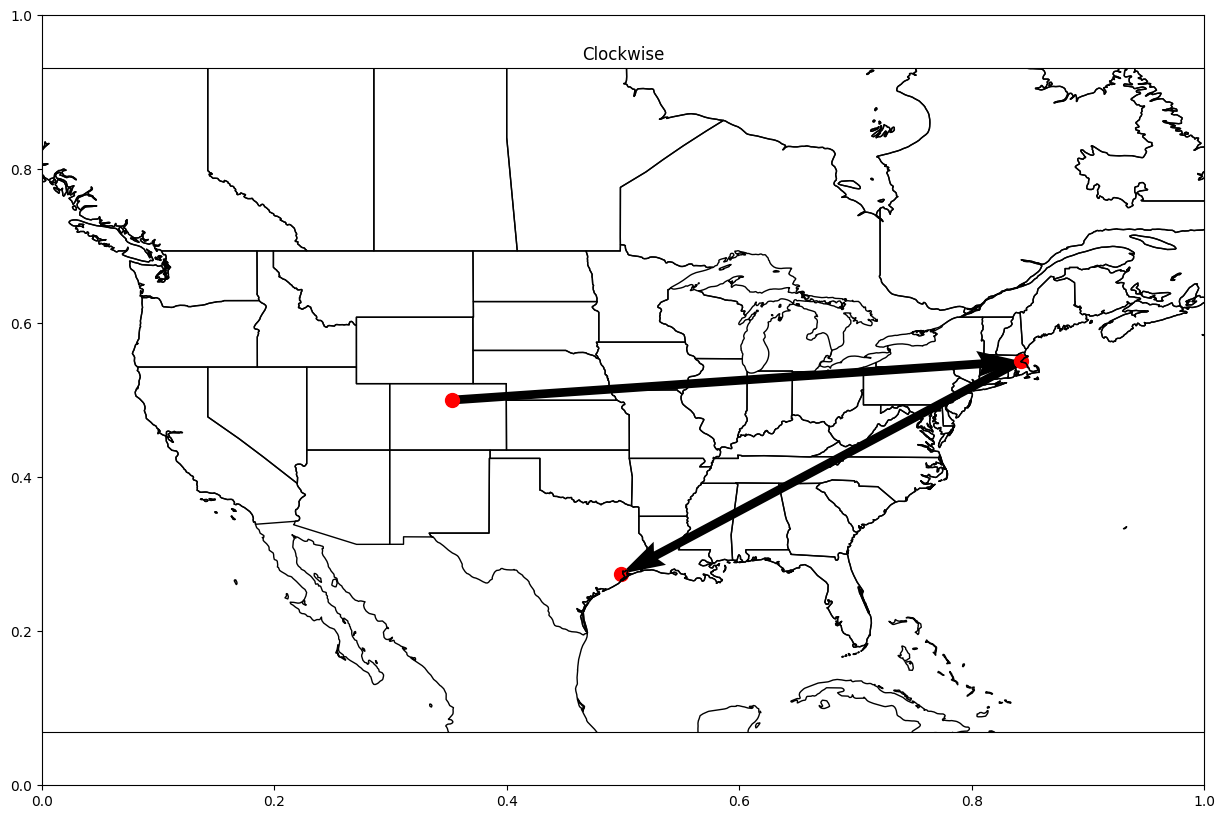

In [50]:
plot_clockwise(["boulder", "boston", "houston"], -130, -60, 20, 60)

counterclockwise -> postive


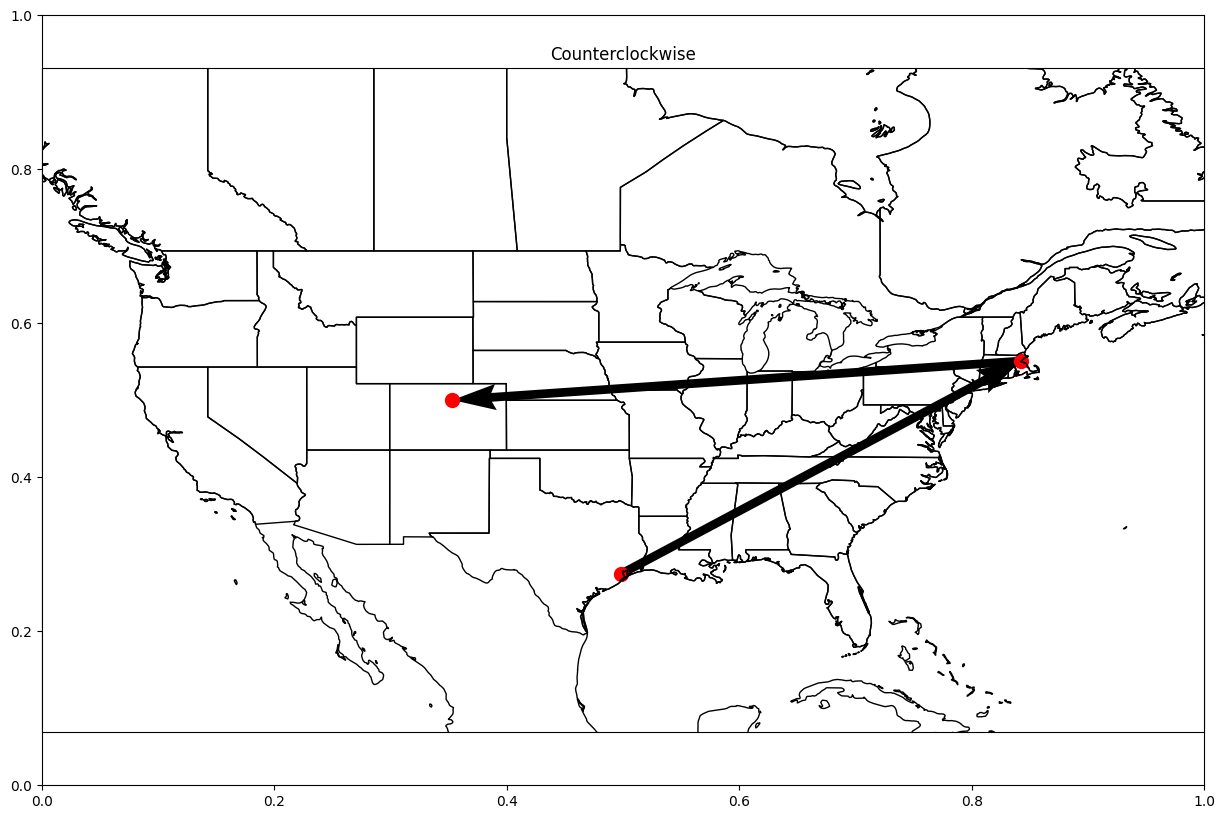

In [51]:
plot_clockwise(["houston", "boston", "boulder"], -130, -60, 20, 60)

counterclockwise -> postive


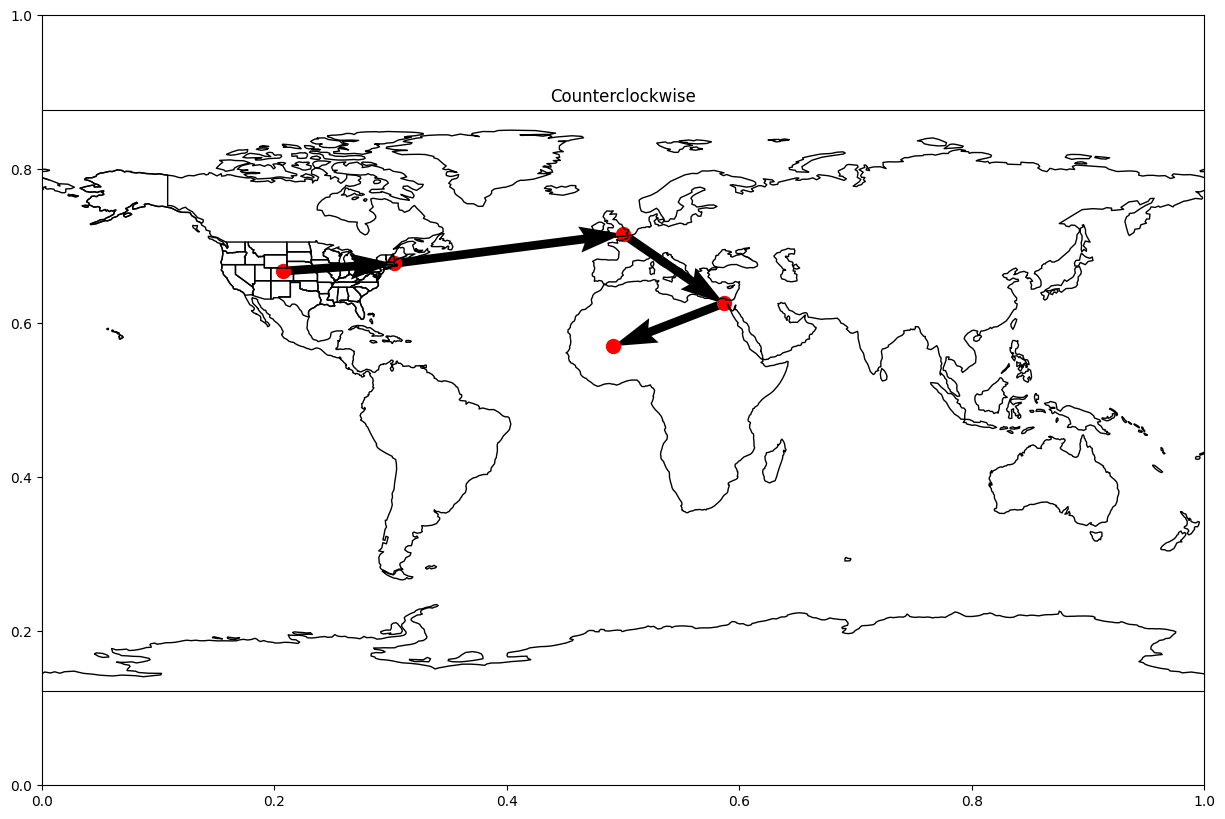

In [52]:
plot_clockwise(["boulder", "boston", "greenwich", "cairo", "timbuktu"])

## Area and Perimeter of quadrilateral patch

In [62]:
def area_of_polygon_projection(poly_pts=None):
    geod = Geod(ellps="WGS84")
    longitudes = [location_df.loc[[pt]]["longitude"].iloc[0] for pt in poly_pts]
    latitudes = [location_df.loc[[pt]]["latitude"].iloc[0] for pt in poly_pts]
    poly_area_m, poly_perimeter_m = geod.polygon_area_perimeter(longitudes, latitudes)
    return abs(poly_area_m) * 1e-6, poly_perimeter_m/1000

In [74]:
def plot_area(pt_lst=None,
                   lon_west=-180, lon_east=180,
                   lat_south=-90, lat_north=90):
    # Set up world map plot
    fig = plt.subplots(figsize=(15, 10))
    projection_map = ccrs.PlateCarree()
    ax = plt.axes(projection=projection_map)
    ax.set_extent([lon_west, lon_east, lat_south, lat_north], crs=projection_map)
    ax.coastlines(color="black")
    ax.add_feature(cfeature.STATES, edgecolor="black")

   # plot points
    longitudes = [location_df.loc[[x]]["longitude"].iloc[0] for x in pt_lst] # longitude
    latitudes = [location_df.loc[[x]]["latitude"].iloc[0] for x in pt_lst] # latitude
    plt.scatter(longitudes, latitudes, s=100, c="red")
    plt.fill(longitudes, latitudes, alpha=0.5)

    area, perimeter = area_of_polygon_projection(pt_lst)
    plt.title(f"Area = {area} km^2, Perimter = {perimeter} km")
    plt.show()

In [75]:
area, perimeter = area_of_polygon_projection(["boulder", "boston",
                                             "arecibo", "houston"])
print(f"Perimeter = {perimeter} km")
print(f"Area = {area} km^2")

Perimeter = 10171.738963248145 km
Area = 5342585.647699828 km^2


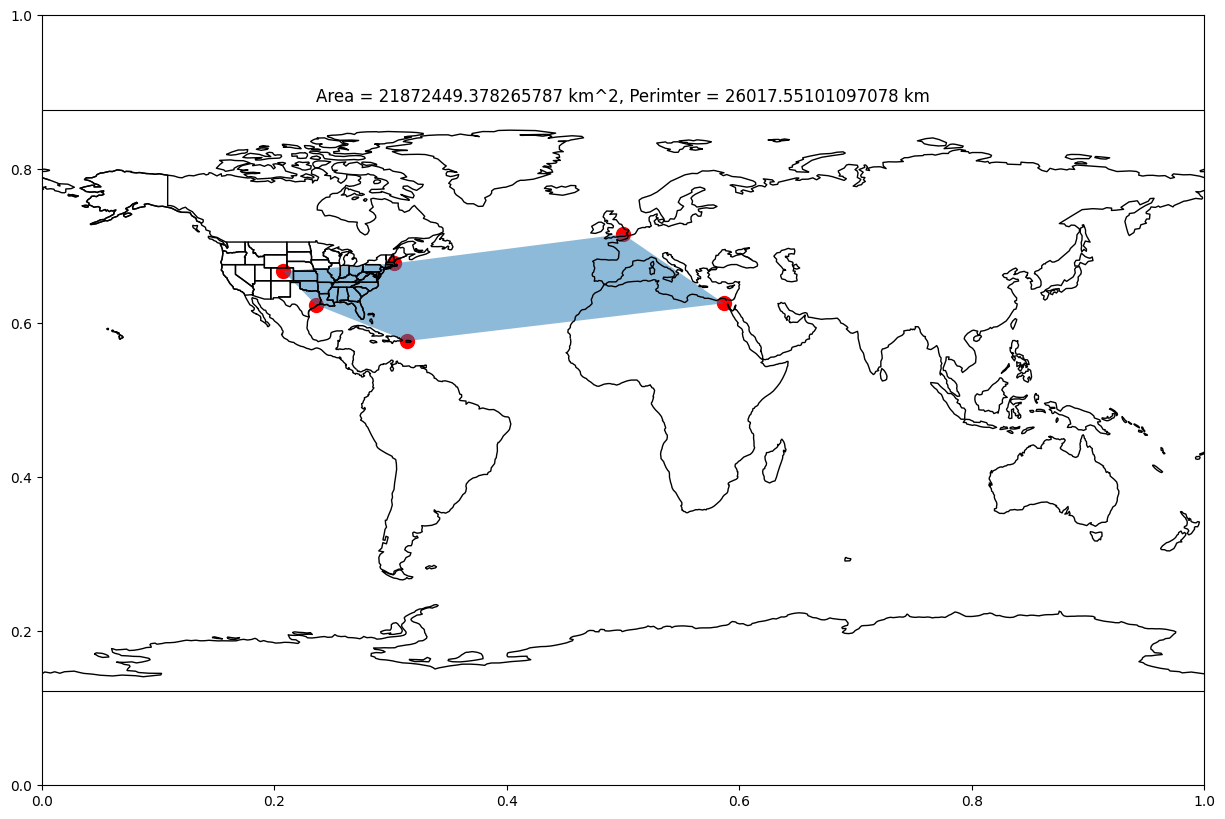

In [82]:
plot_area(["boulder", "boston", "greenwich", "cairo", "arecibo", "houston"])

### TODO
Fix invalid overlapping polygon by re-ordering points into a clockwise order

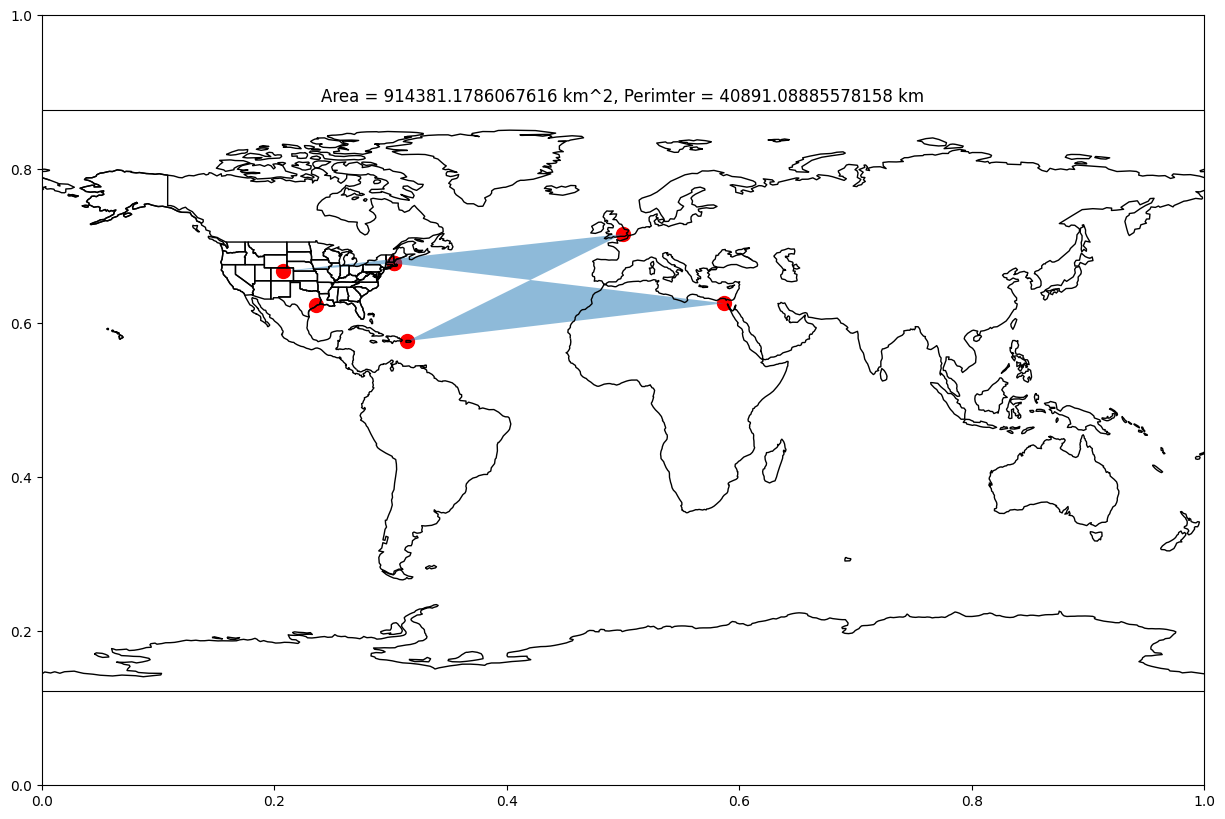

In [91]:
plot_area(["boulder", "boston", "houston", "boston", "cairo", "arecibo", "greenwich"])

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!